## A: Preprocessing of Corporate ESG Reports ##

In [1]:
import requests, io, PyPDF2
import pandas as pd
import spacy
import string, re
import gensim

In [2]:
urlMap = {
    "barclays": "https://home.barclays/content/dam/home-barclays/documents/citizenship/ESG/Barclays-PLC-ESG-Report-2019.pdf",
    "jp morgan chase": "https://impact.jpmorganchase.com/content/dam/jpmc/jpmorgan-chase-and-co/documents/jpmc-cr-esg-report-2019.pdf",
    "morgan stanley": "https://www.morganstanley.com/pub/content/dam/msdotcom/sustainability/Morgan-Stanley_2019-Sustainability-Report_Final.pdf",
    "goldman sachs": "https://www.goldmansachs.com/what-we-do/sustainable-finance/documents/reports/2019-sustainability-report.pdf",
    "hsbc": "https://www.hsbc.com/-/files/hsbc/our-approach/measuring-our-impact/pdfs/190408-esg-update-april-2019-eng.pdf",
    "citi": "https://www.citigroup.com/citi/about/esg/download/2019/Global-ESG-Report-2019.pdf",
    "td bank": "https://www.td.com/document/PDF/corporateresponsibility/2018-ESG-Report.pdf",
    "bank of america": "https://about.bankofamerica.com/assets/pdf/Bank-of-America-2017-ESG-Performance-Data-Summary.pdf",
    "rbc": "https://www.rbc.com/community-social-impact/_assets-custom/pdf/2019-ESG-Report.PDF",
    "macquarie": "https://www.macquarie.com/assets/macq/investor/reports/2020/sections/Macquarie-Group-FY20-ESG.pdf",
    "lloyds": "https://www.lloydsbankinggroup.com/globalassets/documents/investors/2020/2020feb20_lbg_esg_approach.pdf",
    "santander": "https://www.santander.co.uk/assets/s3fs-public/documents/2019_santander_esg_supplement.pdf",
    "bluebay": "https://www.bluebay.com/globalassets/documents/bluebay-annual-esg-investment-report-2018.pdf",
    "lasalle": "https://www.lasalle.com/documents/ESG_Policy_2019.pdf",
    "riverstone": "https://www.riverstonellc.com/media/1196/riverstone_esg_report.pdf",
    "aberdeen standard": "https://www.standardlifeinvestments.com/RI_Report.pdf",
    "apollo": "https://www.apollo.com/~/media/Files/A/Apollo-V2/documents/apollo-2018-esg-summary-annual-report.pdf",
    "bmogan": "https://www.bmogam.com/gb-en/intermediary/wp-content/uploads/2019/02/cm16148-esg-profile-and-impact-report-2018_v33_digital.pdf",
    "vanguard": "https://personal.vanguard.com/pdf/ISGESG.pdf",
    "ruffer": "https://www.ruffer.co.uk/-/media/Ruffer-Website/Files/Downloads/ESG/2018_Ruffer_report_on_ESG.pdf",
    "northern trust": "https://cdn.northerntrust.com/pws/nt/documents/fact-sheets/mutual-funds/institutional/annual-stewardship-report.pdf",
    "hermes investments": "https://www.hermes-investment.com/ukw/wp-content/uploads/sites/80/2017/09/Hermes-Global-Equities-ESG-Dashboard-Overview_NB.pdf",
    "abris capital": "http://www.abris-capital.com/sites/default/files/Abris%20ESG%20Report%202018.pdf",
    "schroders": "https://www.schroders.com/en/sysglobalassets/digital/insights/2019/pdfs/sustainability/sustainable-investment-report/sustainable-investment-report-q2-2019.pdf",
    "lazard": "https://www.lazardassetmanagement.com/docs/-m0-/54142/LazardESGIntegrationReport_en.pdf",
    "credit suisse": "https://www.credit-suisse.com/pwp/am/downloads/marketing/br_esg_capabilities_uk_csam_en.pdf",
    "coller capital": "https://www.collercapital.com/sites/default/files/Coller%20Capital%20ESG%20Report%202019-Digital%20copy.pdf",
    "cinven": "https://www.cinven.com/media/2086/81-cinven-esg-policy.pdf",
    "warburg pincus": "https://www.warburgpincus.com/content/uploads/2019/07/Warburg-Pincus-ESG-Brochure.pdf",
    "exponent": "https://www.exponentpe.com/sites/default/files/2020-01/Exponent%20ESG%20Report%202018.pdf",
    "silverfleet capital": "https://www.silverfleetcapital.com/media-centre/silverfleet-esg-report-2020.pdf",
    "kkr": "https://www.kkr.com/_files/pdf/KKR_2018_ESG_Impact_and_Citizenship_Report.pdf",
    "cerberus": "https://www.cerberus.com/media/2019/07/Cerberus-2018-ESG-Report_FINAL_WEB.pdf",
    "standard chartered": "https://av.sc.com/corp-en/others/2018-sustainability-summary2.pdf"
}

In [3]:
def extractContent(url):
    try:
        response = requests.get(url)
        pdf = PyPDF2.PdfFileReader(io.BytesIO(response.content))  
        text = [pdf.getPage(ii).extractText() for ii in range(0, pdf.getNumPages())]
        return "\n".join(text)
    except:
        return ""

In [4]:
contentMap = {x: extractContent(urlMap[x]) for x in urlMap}
contentMap = {x: contentMap[x] for x in contentMap if len(contentMap[x]) > 0}
{x: len(contentMap[x]) for x in contentMap}

{'barclays': 59376,
 'jp morgan chase': 125166,
 'morgan stanley': 128391,
 'goldman sachs': 164402,
 'hsbc': 189771,
 'citi': 157663,
 'rbc': 142339,
 'macquarie': 76819,
 'santander': 63977,
 'riverstone': 39074,
 'ruffer': 125413,
 'abris capital': 2731,
 'schroders': 53720,
 'lazard': 18279,
 'cinven': 17757,
 'exponent': 30868,
 'kkr': 108504,
 'standard chartered': 67422}

In [5]:
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=['ner'])

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


The following function parses each string by removing whitespace and splitting each string into meaningful sentences. It removes a number of items “contaminating” plain text (section and figure numbers, URLs, and so on) by making heavy use of regular expressions. I encourage you to familiarize yourselves with regular expressions using https://developer.mozilla.org/en-US/docs/Web/JavaScript/Guide/Regular_Expressions/Cheatsheet or Wikipedia, or a number of other excellent online and print sources. Unfortunately, it would take more than a whole day session to discuss regexp in any detail; it will have to remain out of scope

In [6]:
def extractStatements(nlp, text):
    printable = set(string.printable)
    text = "".join(filter(lambda x: x in printable, text))

    lines = []
    prev = ""
    for line in text.split("\n"):
        if(line.startswith(" ") or not prev.endswith(".")):
            prev = prev + " " + line
        else:
            lines.append(prev)
            prev = line
    lines.append(prev)

    sentences = []
    for line in lines:
        line = re.sub(r'^\s?\d+(.*)$', r'\1', line)
        line = line.strip()
        line = re.sub('\s?-\s?', '-', line)
        line = re.sub(r'\s?([,:;\.])', r'\1', line)
        line = re.sub(r'\d{5,}', r' ', line)
        line = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', r' ', line)
        line = re.sub('\s+', ' ', line)

        for part in list(nlp(line).sents):
            sentences.append(str(part).strip())

    return sentences

In [7]:
def lemmatize(nlp, text):
    doc = nlp(text) 
    lemma = []
    for token in doc:
        if(token.lemma_ not in ["-PRON-"]):
            lemma.append(token.lemma_)
          
    gen = gensim.utils.simple_preprocess(" ".join(lemma), deacc=True)
    return " ".join(gen)

In [8]:
esgDf = pd.DataFrame()
for ii in contentMap:
    stmtVar = extractStatements(nlp, contentMap[ii])
    stmtVar = list(filter(lambda x: len(x) > 100, stmtVar))
    lemmaVar = list(map(lambda x: lemmatize(nlp, x), stmtVar))
    newDf = pd.DataFrame({"name": ii, "stmt": stmtVar, "lemma": lemmaVar})
    esgDf = esgDf.append(newDf, ignore_index=True)

In [9]:
#esgDf.to_csv("1.csv")
esgDf

,name,stmt,lemma
0,barclays,Barclays PLC Environmental Social Governance R...,barclays plc environmental social governance r...
1,barclays,These can be found at: Annual and Strategic Re...,these can be find at annual and strategic repo...
2,barclays,Barclays PLC Environmental Social Governance R...,barclays plc environmental social governance r...
3,barclays,Barclays PLC Environmental Social Governance R...,barclays plc environmental social governance r...
4,barclays,It is important to us that all of our stakehol...,it be important to we that all of our stakehol...
...,...,...,...
5764,standard chartered,Indirect renewable energy refers to purchased ...,indirect renewable energy refer to purchase el...
5765,standard chartered,8 Direct renewable energy refers to the gross ...,direct renewable energy refer to the gross cal...
5766,standard chartered,Scaled-up waste data is not representative and...,scale up waste datum be not representative and...
5767,standard chartered,Annual Report For a full review of our perform...,annual report for full review of our performan...


## B: Term Occurrence in ESG Reports ##

In [10]:
from sklearn.feature_extraction import text
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn import preprocessing
import wordcloud

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
fsiStopWords = ["plc", "group", "target", "track", "capital", "holding",
    "report", "annualreport", "esg", "bank", "report", "long", "make"]

for nm in esgDf.name.unique():
    for ii in nm.split(" "):
        fsiStopWords.append(ii)

stopWords = text.ENGLISH_STOP_WORDS.union(fsiStopWords)

In [12]:
largeString = " ".join(esgDf.lemma)
wordCloud0 = wordcloud.WordCloud(
    background_color="white",
    max_words=5000, 
    width=900, 
    height=700, 
    stopwords=stopWords, 
    contour_width=3, 
    contour_color="steelblue")
wordCloud0.generate(largeString)

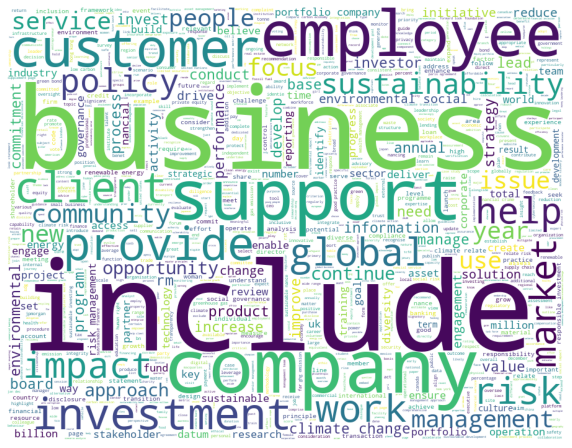

In [13]:
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(wordCloud0)

In [14]:
bigramTfidfVectorizer = text.TfidfVectorizer(stop_words=stopWords, ngram_range=(2, 2), min_df=10, use_idf=True)
bigramTfidf = bigramTfidfVectorizer.fit_transform(esgDf.lemma)

words = bigramTfidfVectorizer.get_feature_names()
totalCounts = np.zeros(len(words))
for ii in bigramTfidf:
    totalCounts += ii.toarray()[0]

count_dict = (zip(words, totalCounts))
count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:10]

words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]

x_pos = np.arange(len(words))

([<matplotlib.axis.XTick at 0x1f36d8fc2b0>,
 [Text(0, 0, 'climate change'),
  Text(1, 0, 'environmental social'),
  Text(2, 0, 'portfolio company'),
  Text(3, 0, 'risk management'),
  Text(4, 0, 'social governance'),
  Text(5, 0, 'responsible investment'),
  Text(6, 0, 'corporate governance'),
  Text(7, 0, 'renewable energy'),
  Text(8, 0, 'product service'),
  Text(9, 0, 'small business')])

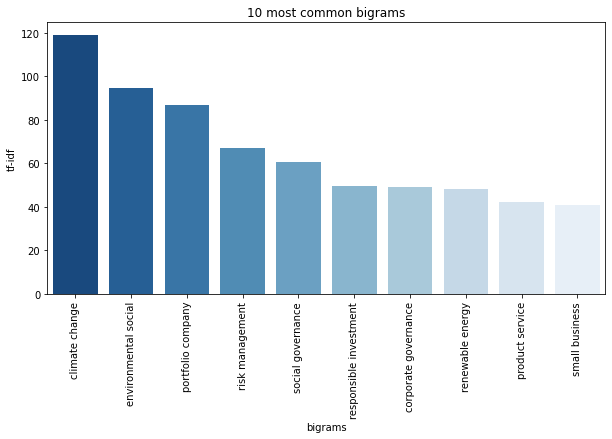

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(title="10 most common bigrams")
plt.xlabel("bigrams")
plt.ylabel("tf-idf")
sns.barplot(x=x_pos, y=counts, palette="Blues_r")
plt.xticks(x_pos, words, rotation=90)

## C: Inference of Report Topics ##

In [16]:
word_tf_vectorizer = text.CountVectorizer(stop_words=stopWords, ngram_range=(1, 1))
wordTF = word_tf_vectorizer.fit_transform(esgDf.lemma)

lda = LatentDirichletAllocation(random_state=42, n_components=9, learning_decay=.3)
lda.fit(wordTF)

LatentDirichletAllocation(learning_decay=0.3, n_components=9, random_state=42)

In [17]:
def topWords(model, feature_names, n_top_words):
    rows = []
    for topic_idx, topic in enumerate(model.components_):
        message = ", ".join([feature_names[ii] for ii in topic.argsort()[:-n_top_words - 1:-1]])
        rows.append(["Topic #%d: " % (topic_idx + 1), message])
    return pd.DataFrame(rows, columns=["topic", "keywords"])

In [18]:
featureNames = word_tf_vectorizer.get_feature_names()
topWords(lda, featureNames, 15)

,topic,keywords
0,Topic #1:,"risk, customer, include, management, business,..."
1,Topic #2:,"employee, emission, year, scope, total, millio..."
2,Topic #3:,"investment, company, asset, management, sustai..."
3,Topic #4:,"support, community, climate, help, work, peopl..."
4,Topic #5:,"energy, renewable, carbon, reduce, use, emissi..."
5,Topic #6:,"company, year, increase, change, sdg, research..."
6,Topic #7:,"company, engagement, portfolio, include, emplo..."
7,Topic #8:,"business, asset, support, market, green, globa..."
8,Topic #9:,"sustainability, environmental, social, governa..."


In [22]:
topicNames = [
    "risk management",
    "emissions",
    "sustainable investment",
    "support community",
    "renewable energy",
    "change company",
    "employee support",
    "green assets",
    "strong governance"
]

In [20]:
def produceWordCloud(model, tf_feature_names, index):
    imp_words_topic = ""
    vocab_comp = zip(tf_feature_names, model.components_[index])

    sorted_words = sorted(vocab_comp, key=lambda x: x[1], reverse=True)[:50]
    for word in sorted_words:
        imp_words_topic = imp_words_topic + " " + word[0]
    
    return wordcloud.WordCloud(background_color="white", width=600, height=600, contour_width=3,
        contour_color="steelblue").generate(imp_words_topic)

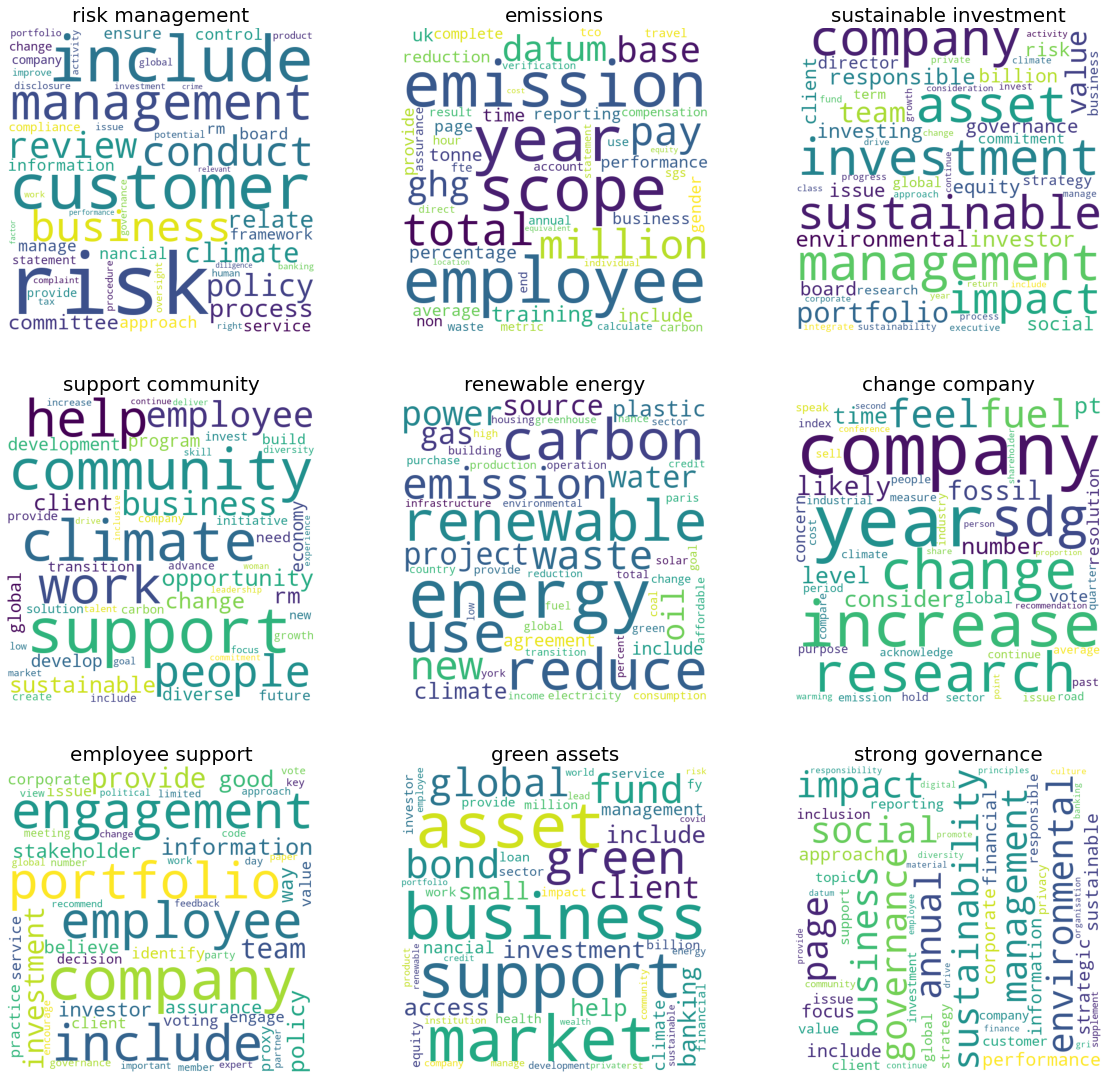

In [23]:
nTopics = len(lda.components_)
fig = plt.figure(figsize=(20, 20 * nTopics / 3))
for ii, topic in enumerate(lda.components_):
    ax = fig.add_subplot(nTopics, 3, ii + 1)
    ax.set_title(topicNames[ii], fontsize=20)
    ax.axis('off')
    ax.imshow(produceWordCloud(lda, featureNames, ii))

In [24]:
transformed = lda.transform(wordTF)
aa = [topicNames[np.argmax(distr)] for distr in transformed]
bb = [np.max(distr) for distr in transformed]

df0 = pd.DataFrame(zip(aa, bb, transformed), columns=["topic", "probability", "probs"])
esgGroup = pd.concat([esgDf, df0], axis=1)
esgGroup.iloc[:,:5]

,name,stmt,lemma,topic,probability
0,barclays,Barclays PLC Environmental Social Governance R...,barclays plc environmental social governance r...,strong governance,0.865916
1,barclays,These can be found at: Annual and Strategic Re...,these can be find at annual and strategic repo...,strong governance,0.370477
2,barclays,Barclays PLC Environmental Social Governance R...,barclays plc environmental social governance r...,strong governance,0.901219
3,barclays,Barclays PLC Environmental Social Governance R...,barclays plc environmental social governance r...,employee support,0.462816
4,barclays,It is important to us that all of our stakehol...,it be important to we that all of our stakehol...,employee support,0.609237
...,...,...,...,...,...
5764,standard chartered,Indirect renewable energy refers to purchased ...,indirect renewable energy refer to purchase el...,renewable energy,0.520006
5765,standard chartered,8 Direct renewable energy refers to the gross ...,direct renewable energy refer to the gross cal...,renewable energy,0.606702
5766,standard chartered,Scaled-up waste data is not representative and...,scale up waste datum be not representative and...,employee support,0.626487
5767,standard chartered,Annual Report For a full review of our perform...,annual report for full review of our performan...,strong governance,0.578739


<AxesSubplot:xlabel='topic', ylabel='name'>

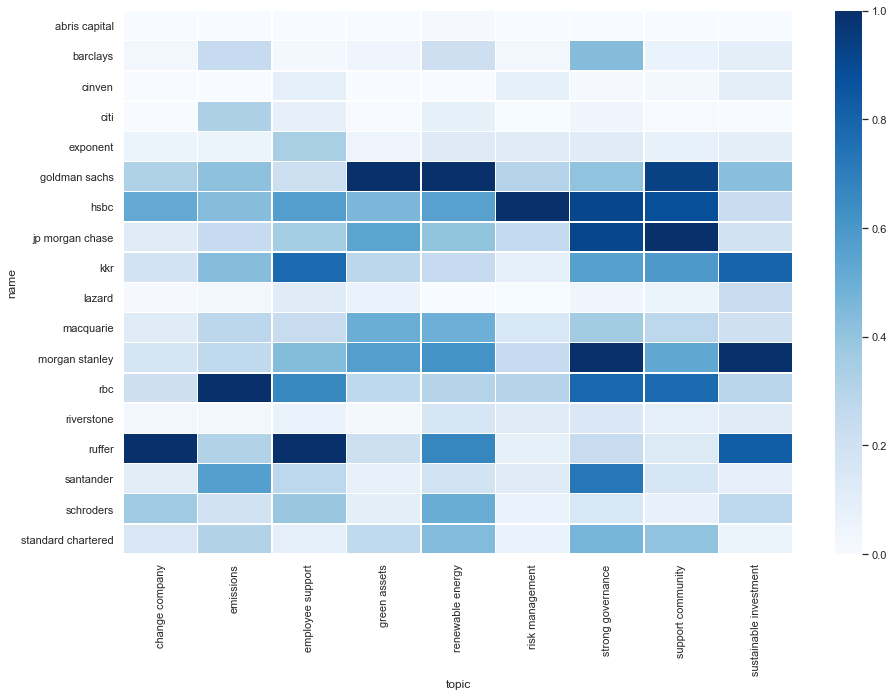

In [25]:
esgFocus = pd.crosstab(esgGroup.name, esgGroup.topic)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

esgFocus_norm = pd.DataFrame(scaler.fit_transform(esgFocus), columns=esgFocus.columns)
esgFocus_norm.index = esgFocus.index

sns.set(rc={"figure.figsize": (15, 10)})
sns.heatmap(esgFocus_norm, annot=False, linewidths=.5, cmap="Blues")

<AxesSubplot:title={'center':'Primary topic distribution'}, xlabel='probability'>

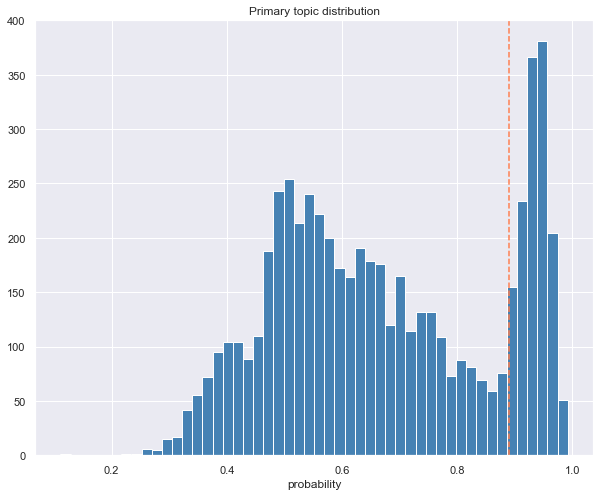

In [26]:
plt.axvline(0.89, color="coral", linestyle="--")
plt.title("Primary topic distribution")
plt.xlabel("probability")
esgGroup.probability.hist(bins=50, figsize=(10, 8), color="steelblue")

## D: Identification of Outlier Topics ##

<AxesSubplot:>

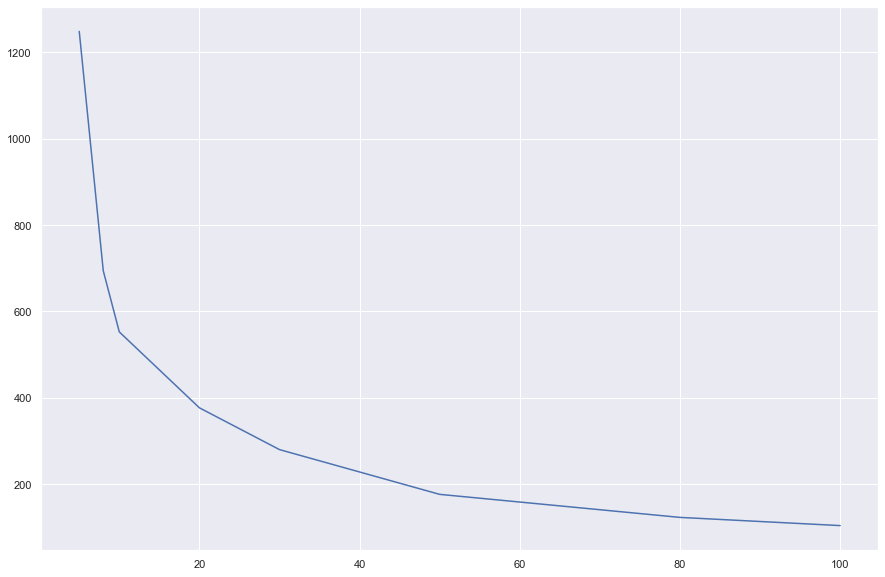

In [27]:
X_train = list(esgGroup.probs)
wsses = []
kk = [5, 8, 10, 20, 30, 50, 80, 100]
for k in kk:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)
    wsses.append(np.sum([np.min(x)**2 for x in kmeans.transform(X_train)])) 
pd.Series(wsses, index=kk).plot()

In [28]:
kmeans = KMeans(n_clusters=20, random_state=42)
kmeans.fit(X_train)

y_dist = [np.min(x) for x in kmeans.transform(X_train)]
distDf = pd.DataFrame(zip(y_dist), columns=["distance"])
esgGroupDist = pd.concat([esgGroup, distDf], axis=1)

In [29]:
esgGroupDist.sort_values(by="distance", inplace=True, ascending=False)
esgGroupDist[esgGroupDist.name == "goldman sachs"]

,name,stmt,lemma,topic,probability,probs,distance
1838,goldman sachs,Paris Climate Agreement: We have actively enga...,paris climate agreement we have actively engag...,risk management,0.373743,"[0.3737431430854112, 0.006945276285569132, 0.0...",0.508195
1687,goldman sachs,After additional diligence into the causes and...,after additional diligence into the cause and ...,risk management,0.374691,"[0.3746914331057652, 0.010102393961081778, 0.0...",0.499352
1447,goldman sachs,"In 2020, as the COVID-19 pandemic continues to...",in as the covid pandemic continue to pose chal...,change company,0.495514,"[0.004447483207548826, 0.004446013762092771, 0...",0.487343
1379,goldman sachs,"In 2019, GSAM raised assets for an equity stra...",in gsam raise asset for an equity strategy tha...,strong governance,0.368671,"[0.003969311243907477, 0.003969072764114404, 0...",0.476382
1746,goldman sachs,GSAM manages the liquidity of its portfolios i...,gsam manage the liquidity of its portfolio in ...,risk management,0.523122,"[0.5231220017266709, 0.004116294875084334, 0.0...",0.475675
...,...,...,...,...,...,...,...
1503,goldman sachs,"For example, we worked with the African Develo...",for example we work with the african developme...,green assets,0.919152,"[0.010103941399403508, 0.010101150432125401, 0...",0.048023
1548,goldman sachs,This effort extends our decade-long support of...,this effort extend our decade long support of ...,green assets,0.911094,"[0.011112128085817026, 0.011111150364192385, 0...",0.039694
1378,goldman sachs,"At GSAM, ESG assets under supervision increase...",at gsam esg asset under supervision increase f...,sustainable investment,0.901212,"[0.012346284689983646, 0.01234849089356872, 0....",0.035160
1276,goldman sachs,While we have been engaged in sustainable nanc...,while we have be engage in sustainable nance f...,sustainable investment,0.901202,"[0.0123460473506667, 0.012353063479479263, 0.9...",0.035149
